# modele de correction

# Étape 1: Préparation de l'environnement

In [ ]:
pip install transformers

In [ ]:
!pip install transformers torch sklearn

In [ ]:
!pip install --upgrade pip

In [ ]:
pip install plotly

In [ ]:
pip install scikit-learn

In [ ]:
pip install torch

In [ ]:
pip install pandas

In [ ]:
pip install wheel

In [ ]:
pip install editdistance 

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install nltk

# Étape 2: Importation des bibliothèques et Étape 3: Chargement, préparation et prétraitement des données

In [3]:
# importation des dépendances

import numpy as np
import pandas as pd
import re
import plotly.express as px
import pickle
from transformers import BertTokenizer
from transformers import BertForTokenClassification
import torch
import nltk.data
import glob
import os
import plotly.express as px
from os import path
import editdistance
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

torch.__version__
transformers.__version__
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:

#  chemin absolu du dossier POCR-ground-truth
icdar_path = os.path.abspath("data_set")

#  chemin complet vers le fichier
file = os.path.join(icdar_path, "training_18M_without_Finnish/FR/FR1/0.txt")

with open(file, "r", encoding="utf-8") as f:
    raw_text = f.readlines()
[s[:50] for s in raw_text]

['[OCR_toInput] Loys, par la grace de Dieu roy de Fr',
 '[OCR_aligned] Loys, par la grace de Dieu roy de Fr',
 '[ GS_aligned] Loys, par la grace de Dieu roy de Fr']

In [ ]:
## telechargement de la bibliotheque punkt 
import nltk
nltk.download("punkt")

# chargement du module de tockenization 

sentence_tokenizer = nltk.data.load('tokenizers/punkt/french.pickle')

In [7]:
def get_common_space_ids(sentence, gs_sentence):
    """Return indices of the spaces in the text which match in the both OCR and GS sentences."""
    
    ocr_space_ids = [match.span()[0] for match in re.finditer(" ", sentence)]
    gs_space_ids = [match.span()[0] for match in re.finditer(" ", gs_sentence)]

    gs_cursor = 0
    new_ocr_space_ids = []
    for i, space_id in enumerate(ocr_space_ids):
        while gs_cursor < len(gs_space_ids) and gs_space_ids[gs_cursor] < space_id:
            gs_cursor += 1

        if gs_cursor < len(gs_space_ids) and gs_space_ids[gs_cursor] == space_id:
            new_ocr_space_ids.append(space_id)
    new_ocr_space_ids.append(len(sentence))
    return new_ocr_space_ids

In [ ]:
########################

def extract_dataset(files, ocr_last_breakline_remove=False):
    aligned_words = []
    words = []
    aligned_gs_words = []
    labels = []

    total_files = len(files)
    for file in files:
        print(file)
        with open(file, "r", encoding="utf-8") as f:
            raw_text = f.readlines()
            
    #   En omettant les 14 premiers symboles qui contiennent la définition de la structure comme "[OCR_toInput] "

        if ocr_last_breakline_remove:
            aligned_ocr = raw_text[1][14:-1]
        else:
            aligned_ocr = raw_text[1][14:]
        aligned_gs = raw_text[2][14:]
        
        # la longueur des textes alignés doit être la même

        assert len(aligned_ocr) == len(aligned_gs)
        file_aligned_words = []
        file_words = []
        file_aligned_gs_words = []
        file_labels = []
        
        # Obtenir des phrases à partir de l'alignement OCRed text
        sentence_spans = sentence_tokenizer.span_tokenize(aligned_ocr)
        
        for sentence_start, sentence_end in sentence_spans:
            sentence = aligned_ocr[sentence_start: sentence_end]
            gs_sentence = aligned_gs[sentence_start: sentence_end]
            
            assert len(gs_sentence) == len(sentence)
            
            sentence_aligned_words = []
            sentence_words = []
            sentence_aligned_gs_words = []
            sentence_labels = []
            
            # Obtenir des indices d'espace entre les jetons, qui sont utilisés pour obtenir le
            # étendues de mots. Ici, un mot peut contenir plus d'un jeton, si le
            # GS sur cette période n'a pas les mêmes mots divisés

            new_ocr_space_ids = get_common_space_ids(sentence, gs_sentence)
            
            word_start = 0
            # Traversée de l'espace ids
            for space_id in new_ocr_space_ids:
                word = sentence[word_start: space_id]

    #          S'il y avait une séquence d'espaces, le mot résultant est vide. Nous l'omettons
                if len(word) == 0:
                    word_start = space_id + 1 
                    continue
                
                trimmed_word = word.replace("@", "")
                gs_word = gs_sentence[word_start: space_id]
                label = int(word != gs_word)
                
                sentence_labels.append(label)
                sentence_aligned_words.append(word)
                sentence_words.append(trimmed_word)
                sentence_aligned_gs_words.append(gs_word) 
                
                word_start = space_id + 1
                
            file_aligned_words.append(sentence_aligned_words)
            file_words.append(sentence_words)
            file_aligned_gs_words.append(sentence_aligned_gs_words)
            file_labels.append(sentence_labels)
        
        aligned_words.extend(file_aligned_words)
        words.extend(file_words)
        aligned_gs_words.extend(file_aligned_gs_words)
        labels.extend(file_labels)
    return aligned_words, words, aligned_gs_words, labels
train_files = glob.glob(os.path.join(icdar_path, "training_18M_without_Finnish\*", "*", "*.txt"))
aligned_words, words, aligned_gs_words, labels = extract_dataset(train_files)

<Axes: >

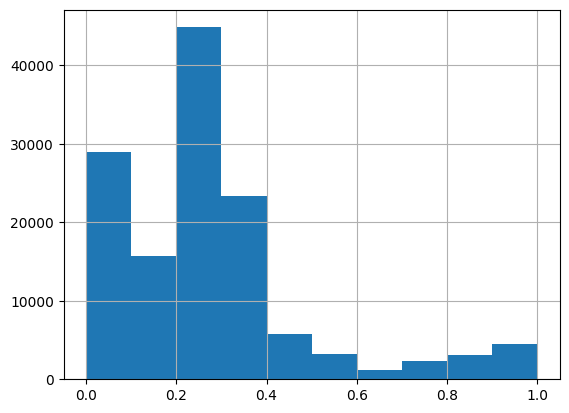

In [10]:
######################## calcul et affichage de la distanc de levinstein de notre corpus
sent_stat = pd.DataFrame({"ocr_sentence": aligned_words, "gs_sentence": aligned_gs_words})

def compute_sent_edit_distance(x):
    ''' Compute sentence edit distance normalized by the length of the sentence'''
    ocr_sent = "".join(x['ocr_sentence'])
    gs_sent = "".join(x['gs_sentence'])
    return editdistance.distance(ocr_sent, gs_sent) / max(len(ocr_sent), len(gs_sent))

sent_stat["sent_edit_distance"] = sent_stat.apply(compute_sent_edit_distance, axis=1)
### generation du graphique 
sent_stat["sent_edit_distance"].hist()

In [11]:
########################## comptage des bonne et mauvaise phrase de notre corpus

MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE = 0.4
total_sent = sent_stat.shape[0]
good_sent = (sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum()
good_sent_ratio = good_sent / total_sent
print("Bonnes phrases: %s\nPhrases totales: %s\nRatio de bonnes phrases: %s" % (good_sent, total_sent, good_sent_ratio))

Bonnes phrases: 113476
Phrases totales: 132829
Ratio de bonnes phrases: 0.8543013950266884


In [13]:
################# visuel de distance d'edition entre les phrase ocr et la traduction de reference

good_sentences_stat = sent_stat[sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]
i = random.randint(0, good_sentences_stat.shape[0] - 1)

good_sentences_stat[i: i + 5].sort_values("sent_edit_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_edit_distance
64060,"[Ofnimalifation, unb, Begetatton,, und, der, ©...","[@Animaliſation, und, Vegetation,, und, der, @...",0.270492
64061,"[Und, ift, nicht, nodh, jegt Öleifernt, v@ölli...","[Und, iſt, nicht, noch, jetztGleiſe@n@, voͤlli...",0.262295
64063,"[Den, w@ürbtgs, nur, f@ür, bdie, heutigen, gilt.]","[Den, wuͤrdig@, nur, fuͤr, @die, heutigen, gilt.]",0.228571
64062,"[Dte, Unts, find, fcbr, unrveife, Droducte, ge...","[Die, Un@i, ſind, ſehr, unr@eife, Producte, ge...",0.219512
64059,"[jeder, bie, feinige, gur, alleing@ültigen, ma...","[jeder, die, ſeinige, zur, alleinguͤltigen, ma...",0.125000


In [14]:
################## distance dd'edition des phrase a exclure  de notre corpus car edit dist>0.4

noisy_sentences_stat = sent_stat[sent_stat["sent_edit_distance"] > MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]
i = random.randint(0, noisy_sentences_stat.shape[0] - 1)

noisy_sentences_stat[i: i + 2].sort_values("sent_edit_distance", ascending=False)

,ocr_sentence,gs_sentence,sent_edit_distance
109536,"[termino, @del, Blasón.]","[Chr@on., lib., 2. cap.]",0.833333
109535,"[Circ@@@ula@ción@@, de, la,, @@s@angre, es, @u...","[cercó à Babylonia, de, mu-, ros. cosa, en, cí...",0.817308


In [ ]:
################## creation des fichier d'entrainement 

words = np.array(words, dtype=object)[good_sentences_stat.index.tolist()].tolist()
labels = np.array(labels, dtype=object)[good_sentences_stat.index.tolist()].tolist()
pickle.dump(words, open("train_ed_filtered_words.pickle", "wb"))
pickle.dump(labels, open("train_ed_filtered_labels.pickle", "wb"))

In [ ]:
###########################

test_files = glob.glob(os.path.join(icdar_path, "evaluation_4M_without_Finnish\*", "*", "*.txt"))
test_aligned_words, test_words, test_aligned_gs_words, test_labels = extract_dataset(test_files, True)
test_sent_stat = pd.DataFrame({"ocr_sentence": test_aligned_words, "gs_sentence": test_aligned_gs_words})
test_sent_stat["sent_edit_distance"] = test_sent_stat.apply(compute_sent_edit_distance, axis=1)
test_sent_stat["sent_edit_distance"].hist()
print("Bonnes phrases: %s\nTotal de phrases: %s\nRatio de Bonnes phrases: %s" % ((test_sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum(), test_sent_stat.shape[0], (test_sent_stat["sent_edit_distance"] < MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE).sum() / test_sent_stat.shape[0]))
test_good_sentences_stat = test_sent_stat[test_sent_stat["sent_edit_distance"] <= MAXIMUM_AVERAGE_EDIT_DISTANCE_RATE]
eval_words = np.array(test_words, dtype=object)[test_good_sentences_stat.index.tolist()].tolist()
eval_labels = np.array(test_labels, dtype=object)[test_good_sentences_stat.index.tolist()].tolist()
pickle.dump(eval_words, open("test_ed_filtered_words.pickle", "wb"))
pickle.dump(eval_labels, open("test_ed_filtered_labels.pickle", "wb"))

In [20]:
#################

eval_words = pickle.load(open("test_ed_filtered_words.pickle", "rb"))
eval_labels = pickle.load(open("test_ed_filtered_labels.pickle", "rb"))
words = pickle.load(open("train_ed_filtered_words.pickle", "rb"))
labels = pickle.load(open("train_ed_filtered_labels.pickle", "rb"))

In [21]:
#######

pos_labels_count = sum(sum(sent_labels) for sent_labels in labels)
total_labels_count = sum(len(sent_labels) for sent_labels in labels)
print(f"Faute d'orthographe: {pos_labels_count}, total: {total_labels_count}, typo_rate: {pos_labels_count / total_labels_count}")

Faute d'orthographe: 1317158, total: 2469096, typo_rate: 0.5334575893363401


In [22]:
# Initialisation du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [23]:
############### Fonction pour extraire et tokeniser les sentences
def tokenize_and_preserve_labels(sentence, text_labels):
    """ Tokenize sentence into BERT subtokens."""
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenisation 
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

#     ajout des CLS et SEP tokens
    tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"]
    labels = [0] + labels + [0]
    return tokenized_sentence, labels

In [24]:
##############
def truncate_or_pad(arr, max_sequence_length):
    """ Truncate or pad the `arr` according the maximum sequence length"""
    
    return arr[:max_sequence_length] + [tokenizer.pad_token_id] * (max_sequence_length - len(arr))

In [25]:
####################
def prepare_dataset(words, labels, max_sequence_length=100):
    """Extract inputs, tags and masks tensors from the dataset"""

    tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(words, labels)]

    tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
    tokenized_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
    input_ids = np.array([truncate_or_pad(tokenizer.convert_tokens_to_ids(txt), max_sequence_length) for txt in tokenized_texts], dtype='long')
    subtoken_labels = np.array([truncate_or_pad(sentence_labels, max_sequence_length) for sentence_labels in tokenized_labels], dtype='long')
    attention_masks = [[int(i != 0) for i in ii] for ii in input_ids]

    inputs = torch.tensor(input_ids, dtype=torch.long)
    tags = torch.tensor(subtoken_labels, dtype=torch.long)
    masks = torch.tensor(attention_masks, dtype=torch.long)
    return inputs, tags, masks
MAX_SEQUENCE_LENGTH = 100
tr_inputs, tr_tags, tr_masks = prepare_dataset(words, labels, MAX_SEQUENCE_LENGTH)
val_inputs, val_tags, val_masks = prepare_dataset(eval_words, eval_labels, MAX_SEQUENCE_LENGTH)

In [26]:
########################
prepared_data_dir = "prepared_data"
os.makedirs(prepared_data_dir, exist_ok=True)

# sauvegarde des pickled data et instance tokenizer. 

pickle.dump(tr_inputs, open(path.join(prepared_data_dir, "tr_inputs.pickle"), "wb"))
pickle.dump(val_inputs, open(path.join(prepared_data_dir, "val_inputs.pickle"), "wb"))
pickle.dump(tr_tags, open(path.join(prepared_data_dir, "tr_tags.pickle"), "wb"))
pickle.dump(val_tags, open(path.join(prepared_data_dir, "val_tags.pickle"), "wb"))
pickle.dump(tr_masks, open(path.join(prepared_data_dir, "tr_masks.pickle"), "wb"))
pickle.dump(val_masks, open(path.join(prepared_data_dir, "val_masks.pickle"), "wb"))
tokenizer.save_pretrained(prepared_data_dir)

# chargement des pickled data instance tokenizer

tokenizer = BertTokenizer.from_pretrained(prepared_data_dir)
tr_inputs = pickle.load(open(path.join(prepared_data_dir, "tr_inputs.pickle"), "rb"))
val_inputs = pickle.load(open(path.join(prepared_data_dir, "val_inputs.pickle"), "rb"))
tr_tags = pickle.load(open(path.join(prepared_data_dir, "tr_tags.pickle"), "rb"))
val_tags = pickle.load(open(path.join(prepared_data_dir, "val_tags.pickle"), "rb"))
tr_masks = pickle.load(open(path.join(prepared_data_dir, "tr_masks.pickle"), "rb"))
val_masks = pickle.load(open(path.join(prepared_data_dir, "val_masks.pickle"), "rb"))


#### a voir si on va conservé ou pas cette partie du code


# Fonction pour extraire et tokeniser les sections [OCR_toInput] et [GS_aligned]


# Étape 5: Création du modèle

In [35]:
from transformers import BertModel
class OCRPostCorrectionModel(nn.Module):
    def __init__(self, num_labels, hidden_dropout_prob=0.1):
        super(OCRPostCorrectionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512, num_labels)  # 512 car LSTM bidirectionnel

    def forward(self, input_ids, attention_mask=None):
        # Obtenir les sorties de BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Application des dropout aux sorties BERT
        bert_output = self.dropout(bert_output.last_hidden_state)
        
        #  les sorties BERT sont passze a travers le LSTM bidirectionnel
        lstm_output, _ = self.lstm(bert_output)
        
        # Application du dropout aux sorties du LSTM
        lstm_output = self.dropout(lstm_output)
        
        # les sorties du LSTM sont passez a travers le classificateur
        logits = self.classifier(lstm_output)
        
        return logits


# Nombre de caractères uniques dans le vocabulaire
num_labels = 135  # a définir en fonction de l'analyse de données d'entrainement

model = OCRPostCorrectionModel(num_labels=num_labels)


In [36]:
#################
BATCH_SIZE = 32
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, pin_memory=True, num_workers=2, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
######################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRPostCorrectionModel(num_labels)
model.to(device)

In [ ]:
#################################
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if "bias" in n],
        'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if "bias" not in n],
        'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

# Étape 6: Entraînement du modèle

In [40]:
######################## entrainement du model BERT Multilingue ##################################

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
## Store the average loss and accuracy after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
training_acc, val_acc = [], []
best_valid_loss = float('inf')
best_valid_acc = 0

best_acc_output_dir = "OCRPostCorrectionModel_best_acc_all" 
best_loss_output_dir = "OCRPostCorrectionModel_best_loss_all"

# Create output directory
os.makedirs(best_acc_output_dir, exist_ok=True)
os.makedirs(best_loss_output_dir, exist_ok=True)

print("Best validation accuracy model location: %s" % best_acc_output_dir)
print("Best validation loss model location: %s" % best_loss_output_dir)
all_predictions = []
all_true_labels = []
all_masks = []

for epoch in range(epochs):
    print(f"Epoch:{epoch}")
    

    ##### Puting our model into training mode.
    model.train()
    total_loss = 0

    # Training loop
    true_labels = []
    logits_list = []
    label_ids_list = []
    for step, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
    # for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        
        logits = model(b_input_ids, attention_mask=b_input_mask)
        loss_fct = nn.CrossEntropyLoss()
        # Only keep active parts of the loss
        active_loss = b_input_mask.view(-1) == 1
        active_logits = logits.view(-1, model.num_labels)
        active_labels = torch.where(
            active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels)
        )
        loss = loss_fct(active_logits, active_labels)
        
        logits = logits.detach()
        logits_list.append(logits)
        true_labels.extend(b_labels)

        #  calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
      
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    
    predictions = [list(p) for logits in logits_list for p in np.argmax(logits.to("cpu").numpy(), axis=2)]
    true_labels = [tl.to("cpu").numpy() for tl in true_labels]
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nTraining loss: {}".format(avg_train_loss))
                                  
    b_input_mask_list = b_input_mask.cpu().numpy().tolist()
    pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list)
                                 for p_i, l_i, a_i in zip(p, l, a) if a_i]
    valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list)
                                  for l_i, a_i in zip(l, a) if a_i]

    acc = accuracy_score(pred_tags, valid_tags)
    print("Training Accuracy: {}".format(acc))
    training_acc.append(acc)

    loss_values.append(avg_train_loss)



    # After the completion of each training epoch, we measure our performance on
    # our validation set.

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask)
        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()

        loss_fct = nn.CrossEntropyLoss()
        # Only keep active parts of the loss
        active_loss = b_input_mask.view(-1) == 1
        active_logits = logits.view(-1, model.num_labels)
        active_labels = torch.where(
            active_loss, b_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(b_labels)
        )
        loss = loss_fct(active_logits, active_labels).item()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += loss
        logits = logits.detach().cpu().numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    b_input_mask_list = b_input_mask.cpu().numpy().tolist()
    pred_tags = [p_i for p, l, a in zip(predictions, true_labels, b_input_mask_list)
                                 for p_i, l_i, a_i in zip(p, l, a) if a_i]
    valid_tags = [l_i for l, a in zip(true_labels, b_input_mask_list)
                                  for l_i, a_i in zip(l, a) if a_i]
    acc = accuracy_score(pred_tags, valid_tags)
    all_predictions.append(predictions)
    all_true_labels.append(true_labels)
    all_masks.append(b_input_mask_list)
    
    print("Validation Accuracy: {}".format(acc))
    val_acc.append(acc)
    
    
    if eval_loss < best_valid_loss:
        best_valid_loss = eval_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path.join(best_loss_output_dir, "model_BERTLSTM"))
        tokenizer.save_pretrained(best_loss_output_dir)
    
    if acc > best_valid_acc:
        best_valid_acc = acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path.join(best_acc_output_dir, "model_BERTLSTM"))
        tokenizer.save_pretrained(best_acc_output_dir)

Best validation accuracy model location: OCRPostCorrectionModel_best_acc_all
Best validation loss model location: OCRPostCorrectionModel_best_loss_all
Epoch:0


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [8:01:45<00:00,  8.15s/it]



Training loss: 0.190893604859924
Training Accuracy: 0.8930232558139535
Validation loss: 0.18652704143817772
Validation Accuracy: 0.8553557466770915
Epoch:1


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [8:03:07<00:00,  8.17s/it]



Training loss: 0.14018408740099497
Training Accuracy: 1.0
Validation loss: 0.17576388356678377
Validation Accuracy: 0.8866301798279906
Epoch:2


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [8:01:58<00:00,  8.15s/it]



Training loss: 0.11160267396190149
Training Accuracy: 0.9863013698630136
Validation loss: 0.18435529410302387
Validation Accuracy: 0.8780297107114934
Epoch:3


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [8:02:04<00:00,  8.15s/it]



Training loss: 0.08952962653041895
Training Accuracy: 0.9867256637168141
Validation loss: 0.2002862938334455
Validation Accuracy: 0.8780297107114934
Epoch:4


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [8:02:18<00:00,  8.16s/it]



Training loss: 0.0736272328118115
Training Accuracy: 0.9782608695652174
Validation loss: 0.22219604446742117
Validation Accuracy: 0.8788115715402658


# Tracer les Courbes de Perte et de Précision

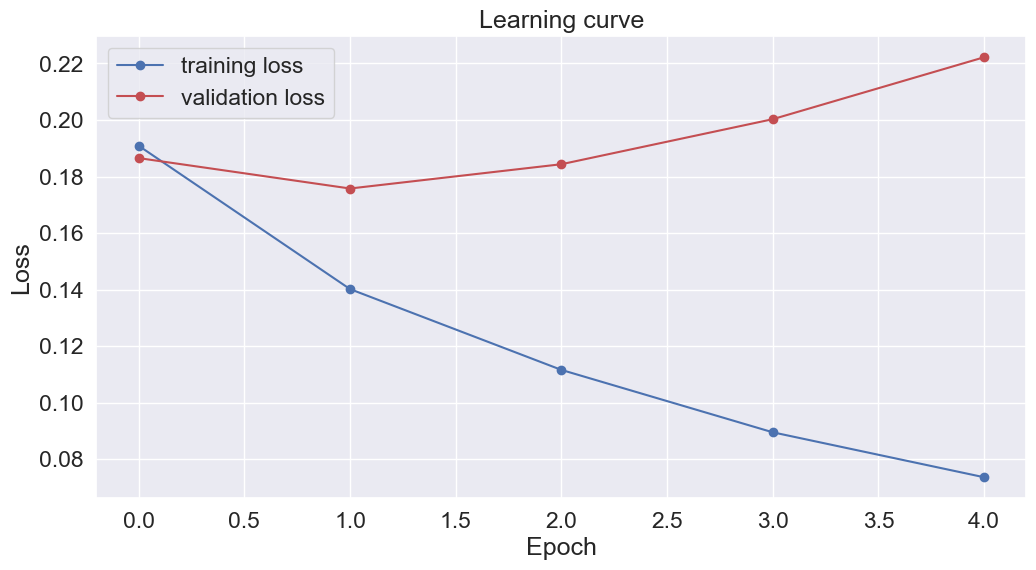

In [41]:
# tracage de la courbe d'apprentissage

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
## chargement du model

output_dir = "OCRPostCorrectionModel_best_loss_all"
tokenizer1 = BertTokenizer.from_pretrained(output_dir)

model1 = OCRPostCorrectionModel(num_labels)
checkpoint = torch.load(path.join(output_dir, "model_BERTLSTM"))
model1.load_state_dict(checkpoint['model_state_dict'])
# Copy the model to the CPU.
model1.to(device)
model1.eval()

# test de correctio

In [67]:
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from os import path
import numpy as np


num_labels = 135  
output_dir = "OCRPostCorrectionModel_best_loss_all"  #
model_filename = "model_BERTLSTM"  # Nom du fichier de modèle enregistré


class OCRPostCorrectionModel(nn.Module):
    def __init__(self, num_labels, hidden_dropout_prob=0.1):
        super(OCRPostCorrectionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512, num_labels)  # 512 car LSTM est bidirectionnel

    def forward(self, input_ids, attention_mask=None):
        # Obtenir les sorties de BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Application des dropout aux sorties BERT
        bert_output = self.dropout(bert_output.last_hidden_state)
        
        #  les sorties BERT sont passze a travers le LSTM bidirectionnel
        lstm_output, _ = self.lstm(bert_output)
        
        # Application du dropout aux sorties du LSTM
        lstm_output = self.dropout(lstm_output)
        
        # les sorties du LSTM sont passez a travers le classificateur
        logits = self.classifier(lstm_output)
        
        return logits


# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Charger le modèle
model = OCRPostCorrectionModel(num_labels)
model_path = path.join(output_dir, model_filename)

# Vérifier si le fichier de modèle existe
if path.exists(model_path):
    # Charger l'état du modèle
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    print(f"Le fichier de modèle {model_path} n'existe pas.")

# Placer le modèle sur le périphérique approprié (graphique ou cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Texte à corriger
text_to_correct = "J'ai un çh1en et un chta ! Ils sont trop mignons et ils @iment jouer avec leurs jouets, mais il faut que je nettoie leur litière régulièrement ? "

# Prétraiter le texte avec le tokenizer
inputs = tokenizer(text_to_correct, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

# Passez le texte à travers le modèle pour obtenir des prédictions
with torch.no_grad():
    logits = model(inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))

# Obtenez les indices de tokens prédits
predicted_token_ids = torch.argmax(logits, dim=-1)

# Convertissez les indices de tokens prédits en texte
predicted_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

print("Texte original: ", text_to_correct)
print("Texte corrigé: ", predicted_text)


Texte original:  J'ai un çh1en et un chta ! Ils sont trop mignons et ils @iment jouer avec leurs jouets, mais il faut que je nettoie leur litière régulièrement ? 
Texte corrigé:  [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1]


## test sur fichier xml a adapter en fonction de la structure xml

import xml.etree.ElementTree as ET
import torch
from transformers import BertTokenizer

# Charger le tokenizer et le modèle
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertLSTM(num_labels=tokenizer.vocab_size)
model.load_state_dict(torch.load('path_to_your_model.pth'))
model.eval()

# Charger et extraire le texte d'un fichier XML
tree = ET.parse('path_to_your_file.xml')
root = tree.getroot()

# Supposons que le texte à corriger se trouve dans un élément 'text'
text_to_correct = root.find('.//text').text

# Prétraiter le texte
inputs = tokenizer(text_to_correct, return_tensors='pt', padding=True, truncation=True, max_length=512)

# Faire la prédiction
with torch.no_grad():
    logits = model(inputs['input_ids'])
    predicted_token_ids = torch.argmax(logits, dim=-1)
    corrected_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)

print("Texte corrigé: ", corrected_text)
